In [97]:
import xarray as xr
import xesmf as xe
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import dask
import cftime
import random
import glob
import matplotlib.gridspec as gs
import xgcm

In [2]:
from dask.distributed import Client, LocalCluster
client = Client()
client

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45131 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/45131/status,
Dashboard: /proxy/45131/status,Workers: 7
Total threads: 14,Total memory: 63.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40085,Workers: 7
Dashboard: /proxy/45131/status,Total threads: 14
Started: Just now,Total memory: 63.00 GiB
Comm: tcp://127.0.0.1:46675,Total threads: 2
Dashboard: /proxy/45251/status,Memory: 9.00 GiB
Nanny: tcp://127.0.0.1:34653,


In [53]:
#open random year from control experiment

In [3]:
DS = xr.open_dataset("/g/data/hh5/tmp/zg0866/cm000_APP4_archive/cm000/history/ocn/ocean_month.nc-09601231", use_cftime=True, chunks= {"time":12})

In [17]:
temp_tendency = DS.temp_tendency

In [4]:
sw_heat = DS.sw_heat

In [5]:
temp_advection = DS.temp_sweby_advec

In [6]:
rivermix = DS.temp_rivermix
temp_vdiffuse_sbc = DS.temp_vdiffuse_sbc
sfc_hflux_pme = DS.sfc_hflux_pme

In [7]:
frazil_3d = DS.frazil_3d

In [8]:
temp_vdiffuse_diff_cbt = DS.temp_vdiffuse_diff_cbt

In [9]:
temp_nonlocal_KPP = DS.temp_nonlocal_KPP

In [10]:
temp_submeso = DS.temp_submeso

In [12]:
temp_vdiffuse_k33 = DS.temp_vdiffuse_k33

In [13]:
neutral_diffusion_temp = DS.neutral_diffusion_temp

In [14]:
neutral_gm_temp = DS.neutral_gm_temp

In [15]:
mixdownslope_temp = DS.mixdownslope_temp
temp_sigma_diff = DS.temp_sigma_diff
temp_eta_smooth = DS.temp_eta_smooth

In [49]:
#now look at only the top layer

In [50]:
Qnet_0 = (sw_heat[:,0] + rivermix[:,0] + temp_vdiffuse_sbc[:,0] +sfc_hflux_pme)

In [51]:
Vmix_0 = temp_vdiffuse_diff_cbt[:,0]+temp_nonlocal_KPP[:,0]

In [52]:
misc_mix_0 = temp_eta_smooth +mixdownslope_temp[:,0] + temp_sigma_diff[:,0]

In [41]:
Sum = temp_advection[:,0]+temp_submeso[:,0]+Vmix_0+Qnet_0+frazil_3d[:,0]+temp_vdiffuse_k33[:,0]+neutral_diffusion_temp[:,0]+neutral_gm_temp[:,0]+misc_mix_0

In [42]:
Sum = Sum.compute()

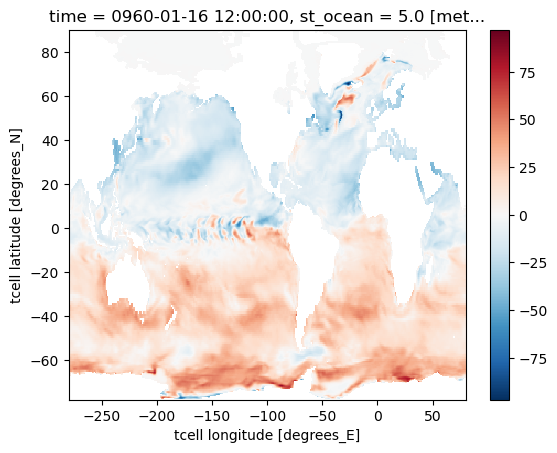

In [43]:
Sum[0].plot()

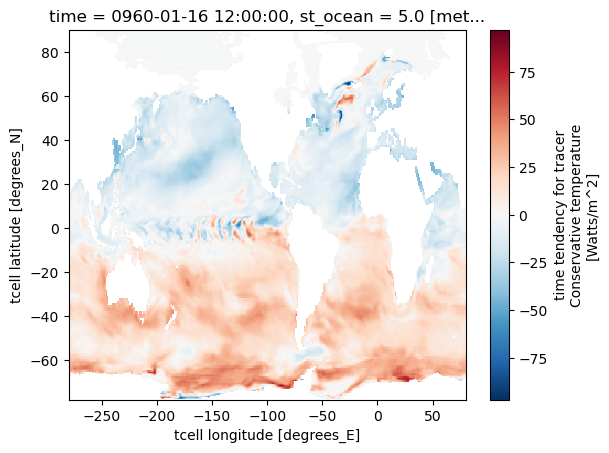

In [44]:
temp_tendency[0,0].plot()

In [55]:
#both these look similar, check the difference

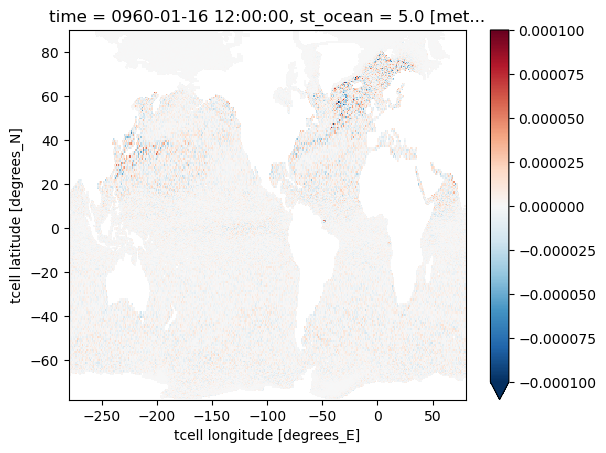

In [48]:
(temp_tendency[0,0] - Sum[0]).plot(vmin = -1e-4)

In [54]:
#This is pretty good for closure, there are probably some very small mixing terms lost somewhere maybe?

In [56]:
#lets integrate each term to 50 meteres to get a sense of the heat in the 50m layer

In [62]:
Qnet_50 = (sw_heat + rivermix + temp_vdiffuse_sbc).sel(st_ocean = slice(0,50)).sum("st_ocean")  + sfc_hflux_pme
#sfc_hflux_pme is only surface layer so cannot integate this term. The dz factor is already included in these fluxes so only need to sum

In [63]:
Vmix_50 = (temp_vdiffuse_diff_cbt+temp_nonlocal_KPP).sel(st_ocean = slice(0,50)).sum("st_ocean")

In [65]:
misc_mix_50 = temp_eta_smooth +(mixdownslope_temp+ temp_sigma_diff).sel(st_ocean = slice(0,50)).sum("st_ocean")
#temp_eta_smooth is a surface only flux so not integrated.

In [68]:
temp_advection_50 = temp_advection.sel(st_ocean = slice(0,50)).sum("st_ocean")
temp_submeso_50 = temp_submeso.sel(st_ocean = slice(0,50)).sum("st_ocean")
frazil_3d_50 = frazil_3d.sel(st_ocean = slice(0,50)).sum("st_ocean")
temp_vdiffuse_k33_50 = temp_vdiffuse_k33.sel(st_ocean = slice(0,50)).sum("st_ocean")
neutral_diffusion_temp_50 = neutral_diffusion_temp.sel(st_ocean = slice(0,50)).sum("st_ocean")
neutral_gm_temp_50 = neutral_gm_temp.sel(st_ocean = slice(0,50)).sum("st_ocean")

In [69]:
Sum50 = temp_advection_50+temp_submeso_50+Vmix_50+Qnet_50+frazil_3d_50+temp_vdiffuse_k33_50+neutral_diffusion_temp_50+neutral_gm_temp_50+misc_mix_50

In [70]:
Sum50 = Sum50.compute()

In [71]:
dTdt_50 = temp_tendency.sel(st_ocean = slice(0,50)).sum("st_ocean")

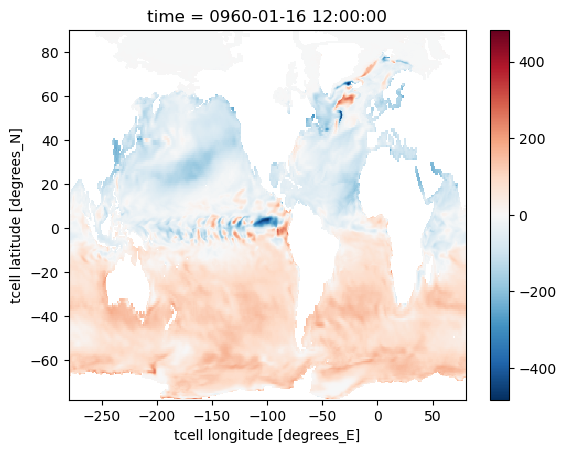

In [72]:
Sum50[0].plot()

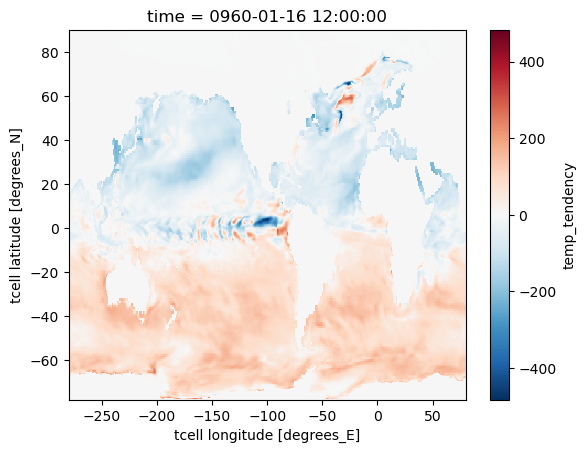

In [73]:
dTdt_50[0].plot()

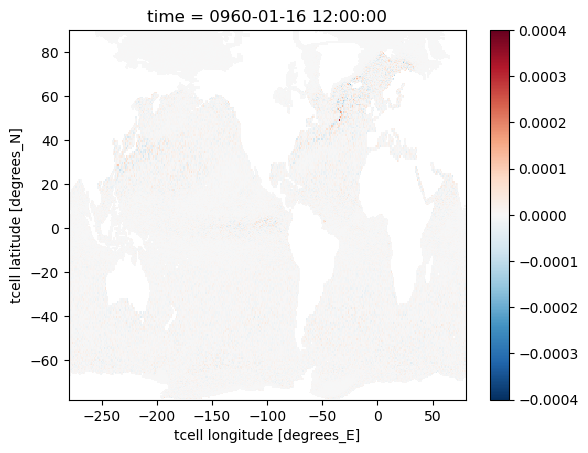

In [80]:
(dTdt_50-Sum50)[0].plot(vmin = -4e-4)

In [81]:
#now lets have a look at an offline calcualtion of heat advection (onyl at surface and see how far off we are.

In [82]:
temp = DS.temp

In [83]:
u = DS.u

In [84]:
v = DS.v

In [85]:
w = DS.wt

In [107]:
dyt = DS.dyt

In [109]:
dxt = DS.dxt

In [110]:
dzt = DS.dht

In [89]:
rho = DS.rho

In [86]:
#regrid to same grid

In [93]:
ds2 = xr.merge([u, v, w])

In [94]:
ds2 = ds2.drop(['geolon_t', 'geolat_t', 'geolat_c', 'geolon_c'])

In [98]:
grid3 = xgcm.Grid(
    ds2,
    coords={"X": {"center": "xt_ocean", "right": "xu_ocean"},
            "Y": {"center": "yt_ocean", "right": "yu_ocean"},
            "Z": {"center": "st_ocean", "left": "sw_ocean"}}
)


In [99]:
grid3

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   xt_ocean --> right
  * right    xu_ocean --> center
Y Axis (periodic, boundary=None):
  * center   yt_ocean --> right
  * right    yu_ocean --> center
Z Axis (periodic, boundary=None):
  * center   st_ocean --> left
  * left     sw_ocean --> center

In [100]:
w1 = grid3.interp(w, axis = "Z", to="center")

In [101]:
v1 = grid3.interp(v, axis = {"X","Y"}, to="center")

In [104]:
u1 = grid3.interp(u, axis = {"X", "Y"}, to="center")

In [111]:
#calculate hhorzintal and vertical temp gradients

In [112]:
dtdy = temp.differentiate("yt_ocean", edge_order = 1)/dyt

In [113]:
dtdx = temp.differentiate("xt_ocean", edge_order = 1)/dxt

In [114]:
dtdz = temp.differentiate("st_ocean", edge_order = 1)/dzt

In [115]:
#multipley by heigth of tcell, density and heat capacity to convert to W/m2

In [133]:
uad1 = (-u1*dtdx*dzt*3992*rho)
vad1 = (-v1*dtdy*dzt*3992*rho)
wad1 = (-w1*dtdz*dzt*3992*rho)

In [134]:
adv_offline_0 = (uad1+vad1+wad1)[:,0].compute()

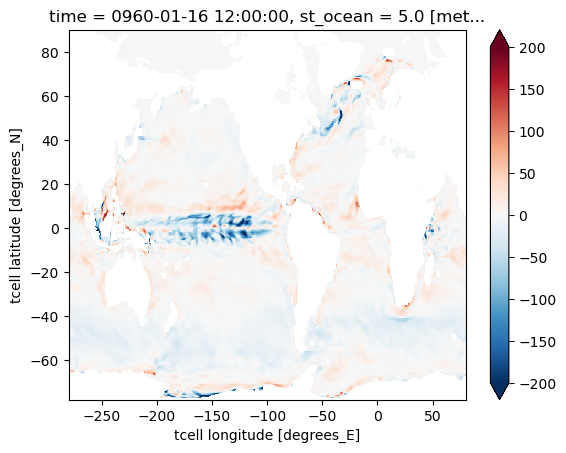

In [135]:
adv_offline_0[0].plot(vmin = -200)

In [136]:
#advection at surface layer

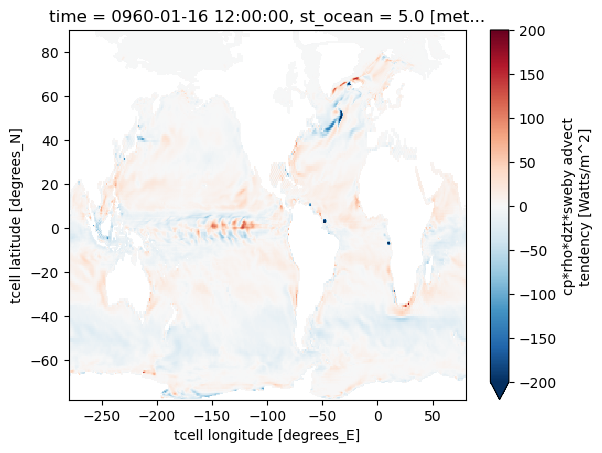

In [137]:
temp_advection[0,0].plot(vmin = -200)

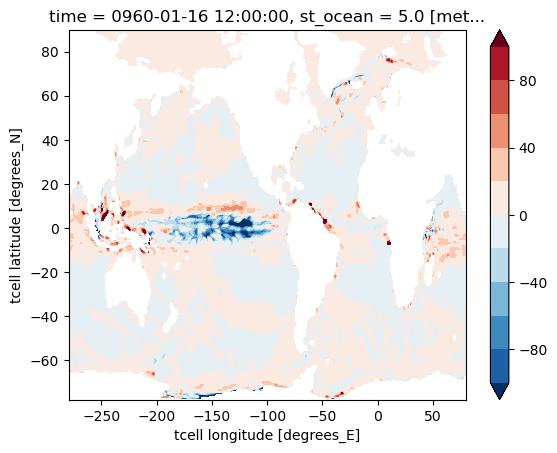

In [143]:
#difference
(adv_offline_0[0] - temp_advection[0,0]).plot.contourf(vmin = -100, levels = 11) 

In [144]:
#so in most places outside of the Pacific Ocean there are only small difference in the heat advection terms

In [146]:
adv_offline_50 = (uad1+vad1+wad1).sel(st_ocean = slice(0,50)).sum("st_ocean")

In [147]:
adv_offline_50 =adv_offline_50.compute()

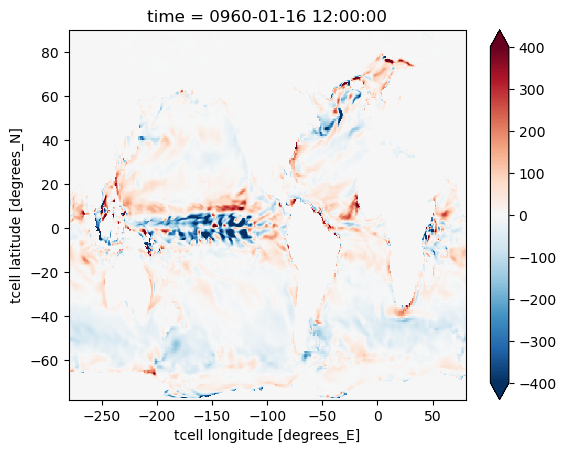

In [149]:
adv_offline_50[0].plot(vmin = -400)

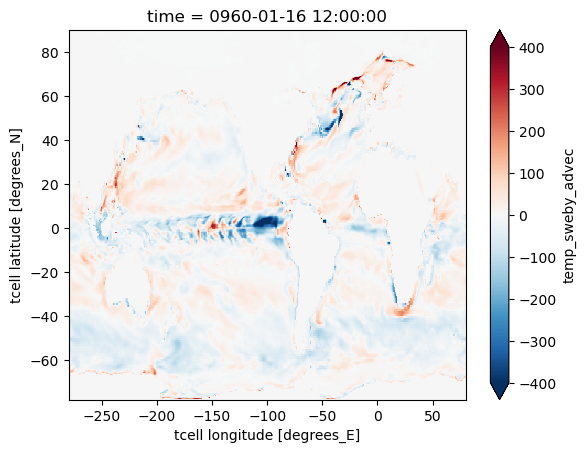

In [150]:
temp_advection_50[0].plot(vmin = -400)

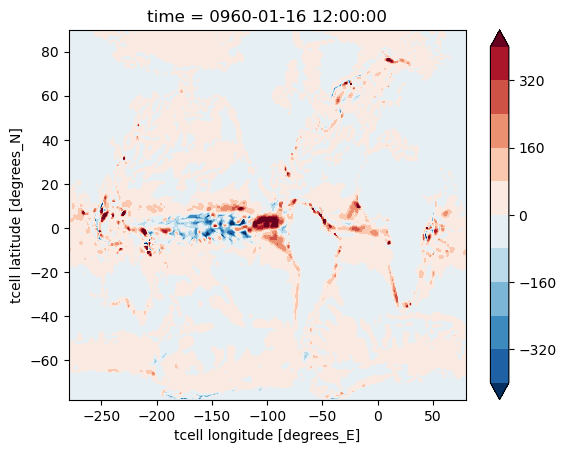

In [153]:
(adv_offline_50- temp_advection_50)[0].plot.contourf(vmin = -400, levels = 11) 